<a href="https://colab.research.google.com/github/kuankuanliu/CS575_parrellelprogram/blob/main/copy_template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CSX46 Class Notebook 1 - Analyzing the Pathway Commons 2 (PC2) database; getting started with igraph


## Part 1:  count the number of different types of biological interactions in Pathway Commons 2

In this notebook, we will learn how to load a biological network from a tab-delimited text file in "edge-list" format. We will also learn how to tabulate counts of edges of different edge types (there are various edge types encoded in the second column of the tab-delimited file) and how to load the edge-list data into an `igraph.Graph` python object (representing an undirected graph) in the `igraph` software packge. We use an edge-list data file that has been obtained from the Pathway Commons 2 database; the file is in a tab-delimited ASCII text format called Simple Interaction Format (SIF).
The SIF (Simple Interaction File) format looks like this:
```
A1BG    controls-expression-of  A2M
A1BG    interacts-with  ABCC6
A1BG    interacts-with  ACE2
A1BG    interacts-with  ADAM10
A1BG    interacts-with  ADAM17
A1BG    interacts-with  ADAM9
```
where the first and third columns contain the names biochemical molecule types (which we sometimes call "biochemical species" if we are being extra-general; the ALLCAPS names are human gene symbols, but they really refer to the *proteins* encoded by the genes). The second column contains one of thirteen different interaction types (i.e., edge labels). The data file originally came from the Pathway Commons 2 database "release 9" (http://www.pathwaycommons.org/archives/PC2/v9/PathwayCommons9.All.hgnc.sif.gz), but in this notebook, we will read the data from an Amazon Web Services (AWS) Simple Storage Service (S3) public storage "bucket" (URL to be provided below), initially using a HTTP request with uncompression on-the-fly (and then later in the notebook, by simply downloading the file into your Google Colab compute instance). In this notebook, you'll be using the Python modules `gzip`, `timeit`, `pandas`, `urllib.request`, `collections`  `operator`, `cairo`, `numpy`, and `igraph`.

### What you will do with the data from the SIF file

- Print the first six lines of the uncompressed data file
- Use a python `timeit` timer to time how long your program takes
- Count how many rows there are in the data file
- Estimate the number of proteins in the database; we'll define them operationally as strings in column 1 or column 3, for which the content of column 2 is one of these interactions: `interacts-with`, `in-complex-with, `neighbor-of`
- Count the total number of unique pairs of interacting molecules (ignoring interaction type)
- Count the number rows for each type of interaction in the database
- Pythonistas: do it using `pandas`, and then do it without using `pandas`

### Step-by-step instructions for Python3:

- Open a file object representing a stream of the remote, compressed data file, using the function `urllib.request.urlopen`
- Open a file object representing a stream of the uncompressed data file, using a `gzip.GzipFile` object
- Start the `timeit` timer
- Read one line at a time, until the end of the file
- Split line on "\t" and pull out the tuple of species1, interaction_type, species2 from the line of text


In order to be able to plot in igraph, we will first need the PyPI package `cairo` to be installed, which requires first installing some APT packages (`libcairo2-dev`, `libjpeg2-dev`, and `libgif-dev`). Then we are also going to have to install the `python-igraph` PyPI package. This package is somewhat peculiar in that the PyPI package name (`python-igraph`) is not the same as the import package name (`igraph`).

In [ ]:
!apt-get install libcairo2-dev libjpeg-dev libgif-dev
!pip install pycairo
# use pip to install python-igraph
!pip install python-igraph

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libcairo2-dev is already the newest version (1.16.0-5ubuntu2).
libgif-dev is already the newest version (5.1.9-2build2).
libjpeg-dev is already the newest version (8c-2ubuntu10).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.


Next, we will need to import the python modules `gzip`, `operator`, `timeit`,  `urllib.request`, `collections`, `pandas`, `csv`, `cairo`, and `igraph`

In [ ]:
import gzip , operator, timeit, urllib.request, collections, pandas, csv, cairo, igraph# add the other packages

Next, we will download (and load into a Python object), a data file that describes a "network" of types of molecules that interact with one another via various types of physical interactions or chemical reactions. Each row in the data file describes a type of interaction involving two specific types of molecules (which could be specific types of proteins or specific types of carbohydrates or whatever). The data file is in a text file format called Simple Interaction Format (SIF), and it is compressed using the GZip compression algorithm. We will download the file using a HTTPS GET request with on-the-fly decompression. We will process that file line-by-line and keep the following variables updated:
- count `intctr`of interactions
- count `linectr` of lines
- set `interactions` of interaction types
- set `proteins` of chemical species names (which are mostly protein names)
- a dictionary-type data structure (`intnamectr`) containing a count of the number of interactions of each interaction type

In [ ]:
compressed_datafile_url = "https://csx46.s3-us-west-2.amazonaws.com/PathwayCommons9.All.hgnc.sif.gz"
interaction_types_ppi = {"interacts-with", "in-complex-with", "neighbor-of"}

start_time = timeit.default_timer()

# initialize the SIF file interaction counter `intctr` to zero
intctr = 0

# initialize the line counter `linectr` to zero
linectr = 0

# make an empty `set` called `interactions`
interactions = set()

# make an empty `set` called `proteins`
proteins = set()


# make a collections.Counter object called `int_name_counter`
int_name_counter = collections.Counter()


# use the `with` keyword to open the URL to the gzipped remote data file
# using `urllib.request.urlopen` as a file descriptor object named `zfd`
with  urllib.request.urlopen(compressed_datafile_url)  as zfd:

    # use the `with` keyword to create a `gzip.GzipFile` object with `zfd`
    # passed to the constructor (in reading mode with `mode="r"`) as
    # variable `fd`
    with gzip.GzipFile(fileobj=zfd, mode="r") as fd:

        # grab one line (as a byte sequence) at a time from `fd` using a `for` loop
        for line in fd:

            # get the line as a string `line_str` using te `str.decode("utf-8")` method
            line_str = line.decode("utf-8")


            # strip the newline at the end of `line_str`, using the `str.rstrip` method
            line_str = line_str.rstrip("\n")


            # if it is one of the first six lines in the file, print it
            if linectr < 6:
                print(line_str)


            # increment the line counter
            linectr += 1


            # and split the resulting string into a list of strings using the `str.split` method
            [prot1, interaction_type, prot2] = line_str.split("\t")


            # increment the counter for this interaction type, using the `Counter.update` method
            # (passing as the sole argument, a single-item list containing the value of `interaction_type`)
            int_name_counter.update([interaction_type])


            # if `interaction_type` is in the set `interaction_types_ppi`:
            if interaction_type in interaction_types_ppi:
                # increment `intctr`
                intctr += 1


                # add `prot1` and `prot2` to the set `proteins` (use the pipe `|` operator)
                proteins |= {prot1, prot2}


                # - construct a string key `min(prot1, prot2) + "-" + max(prot1, prot2)`
                # - add the key to the set `interactions`
                # (the reason why we are doing this is so that we can count up how many unique pairs of
                # proteins there are; but in so doing, because these interactions are not directed,
                # we should count the pair ("RELA","RELB") the same as ("RELB","RELA"). Constructing
                # this key using the "min" and "max" ensures that the key for the tuple ("RELA","RELB")
                # and for the tuple ("RELB","RELA") is just "RELA-RELB", either way-- so those two tuples
                # don't count as distinct interactions (because, in fact, they are not distinct interactions).
                interactions.add(min(prot1, prot2) + "-" + max(prot1, prot2))

# compute a time (in seconds) called `elapsed` as `timeit.default_timer()` minus `start_time`
# print `elapsed`
elapsed = timeit.default_timer() - start_time

A1BG	controls-expression-of	A2M
A1BG	interacts-with	ABCC6
A1BG	interacts-with	ACE2
A1BG	interacts-with	ADAM10
A1BG	interacts-with	ADAM17
A1BG	interacts-with	ADAM9


How long did your program take to run?


In [ ]:
# use string formatting `{elapsed:0.2f}` to print only two digits after the decimal point
print(f"{elapsed:0.2f} sec")

12.67 sec


How many protein-protein interactions are there in the data file?

In [ ]:
# print the value of variable `intctr`
print(intctr)

508480


How many unique protein names are there in the data file?

In [ ]:
# use the `len` function
print(len(proteins))

17531


How many unique pairs of proteins (regarless of interaction type name) are there that interact?

In [ ]:
# use the `len` function
print(len(interactions))

475553


How many interactions are there of each type, in Pathway Commons 2?

In [ ]:
# - define an object `count_items` of class `dict_items` by passing the Counter object to the constructor of a `dict` object and then calling `items()`
# - call `sorted` with the first argument being `dict_items` and then named argument `key` having value `operator.itemgetter(1)`,
#   and then named argument `reverse` having value `True`
count_items = dict(int_name_counter).items()
sorted(count_items, key=operator.itemgetter(1), reverse=True)


[('chemical-affects', 492765),
 ('interacts-with', 325616),
 ('in-complex-with', 182864),
 ('controls-state-change-of', 182450),
 ('catalysis-precedes', 149013),
 ('controls-expression-of', 123232),
 ('consumption-controlled-by', 22830),
 ('controls-production-of', 21494),
 ('controls-phosphorylation-of', 17029),
 ('used-to-produce', 14486),
 ('controls-transport-of', 7574),
 ('reacts-with', 3927),
 ('controls-transport-of-chemical', 3322)]

## Let's do it again, using Pandas

read from the uncompressed data stream, and parse it into a data frame `df`, using `pandas.read_csv`

In [ ]:
# use the `urllib.request.urlopen` and `gzip.GzipFile` method as before, but this time use `pandas.read_csv`
import pandas as pd
with urllib.request.urlopen(compressed_datafile_url) as zfd:
    with gzip.GzipFile(fileobj=zfd, mode="r") as fd:
        df = pd.read_csv(fd, sep="\t", names=["species1", "interaction_type", "species2"])

Use the `pandas.DataFrame.head` method on `df`, to print out the first six lines

In [ ]:
df.head(n=6)

,species1,interaction_type,species2
0,A1BG,controls-expression-of,A2M
1,A1BG,interacts-with,ABCC6
2,A1BG,interacts-with,ACE2
3,A1BG,interacts-with,ADAM10
4,A1BG,interacts-with,ADAM17
5,A1BG,interacts-with,ADAM9


Print the unique types of interactions in the data frame, using the `pandas.core.series.Series.unique` method on `df.interaction_type`:

In [ ]:
print(list(df.interaction_type.unique()))

['controls-expression-of', 'interacts-with', 'controls-phosphorylation-of', 'controls-state-change-of', 'in-complex-with', 'controls-production-of', 'catalysis-precedes', 'controls-transport-of', 'controls-transport-of-chemical', 'chemical-affects', 'consumption-controlled-by', 'reacts-with', 'used-to-produce']


Subset the data frame by interaction type (using the `pandas.core.series.Series.isin` method), to include only the protein-protein interactions, then count rows using `sum`

In [ ]:
ppirows = df.interaction_type.isin(interaction_types_ppi)
print(sum(ppirows))

508480


Make a list of all proteins that occur in a protein-protein interaction, and count the unique protein names by putting them in a `set` and calling `len` on the set

In [ ]:
print(len(set(df["species1"][ppirows].tolist() + df["species2"][ppirows].tolist())))

17531


Count unique protein-protein interaction pairs (specific type of interaction irrelevant), again using `set` and `len`

In [ ]:
print(len(set(df["species1"][ppirows] + "-" + df["species2"][ppirows])))


475553


Count each type of interaction in the database, by subsetting to the `interaction` column and using `value_counts`

In [ ]:
df["interaction_type"].value_counts()

chemical-affects                  492765
interacts-with                    325616
in-complex-with                   182864
controls-state-change-of          182450
catalysis-precedes                149013
controls-expression-of            123232
consumption-controlled-by          22830
controls-production-of             21494
controls-phosphorylation-of        17029
used-to-produce                    14486
controls-transport-of               7574
reacts-with                         3927
controls-transport-of-chemical      3322
Name: interaction_type, dtype: int64

## Part 2: *Introduction to the igraph package and the Pathway Commons network in SIF format*

### Objective: load a network of human molecular interactions and create three igraph `Graph` objects from it (one for protein-protein interactions, one for metabolism interactions, and one for directed protein-protein interactions)

We will use the `igraph` package to load molecular interaction data (in edge-list format) into some networks. Documentation about the Python interface to the `igraph` package can be found here: https://igraph.org/python/#docs

We will be loading the molecular interaction data from a data file in Simple Interaction File (SIF) format, that has been previously downloaded for you from the Pathway Commons 2.0 website (https://www.pathwaycommons.org/) and can be found on the JupyterHub server in `shared/pathway_commons.sif`. Here is a sneak peek at the file format:
```
A1BG    controls-expression-of  A2M
A1BG    interacts-with  ABCC6
A1BG    controls-phosphorylation-of     AKT1
A1BG    controls-state-change-of        AKT1
A1BG    interacts-with  ANXA7
A1BG    interacts-with  CDKN1A
A1BG    interacts-with  CRISP3
A1BG    interacts-with  GDPD1
A1BG    in-complex-with GRB2
A1BG    interacts-with  GRB7
```
As you can see, SIF is a three-column tab-delimited data file format. The first and third columns contain names of molecules (in most cases a protein, but in some cases a metabolite or other chemical). The second column contains an interaction type, of which there are 13 (more about that below).

We are also going to have to install the `python-igraph` python package. This package is not available by default in Google Colab's python notebooks, so we will have to install it using `pip` and then import it in the usual way. This package is somewhat peculiar in that the PyPI package name (`python-igraph`) is not the same as the import package name (`igraph`). Before we can install `igraph`, we will need to install the graphics package `cairo` so that `igraph` can plot networks.

OK, now we are going to download the Pathway Commons data in Gzipped SIF format, to a file and then uncompress the file. We will download it from the URL
```
https://csx46.s3-us-west-2.amazonaws.com/PathwayCommons9.All.hgnc.sif.gz
```
using the command-line tool `wget` and then we will uncompress it using the command-line tool `gunzip`.

In [ ]:
!wget https://csx46.s3-us-west-2.amazonaws.com/PathwayCommons9.All.hgnc.sif.gz
!gunzip -f PathwayCommons9.All.hgnc.sif.gz


--2024-01-09 04:23:05--  https://csx46.s3-us-west-2.amazonaws.com/PathwayCommons9.All.hgnc.sif.gz
Resolving csx46.s3-us-west-2.amazonaws.com (csx46.s3-us-west-2.amazonaws.com)... 52.92.184.90, 52.92.194.250, 3.5.86.187, ...
Connecting to csx46.s3-us-west-2.amazonaws.com (csx46.s3-us-west-2.amazonaws.com)|52.92.184.90|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6072823 (5.8M) [binary/octet-stream]
Saving to: ‘PathwayCommons9.All.hgnc.sif.gz’

PathwayCommons9.All 100%[===================>]   5.79M  16.5MB/s    in 0.4s    

2024-01-09 04:23:06 (16.5 MB/s) - ‘PathwayCommons9.All.hgnc.sif.gz’ saved [6072823/6072823]



Recall that a SIF file is a tab-separated value file. Load the file `PathwayCommons9.All.hgnc.sif`  into a data frame `df` using `pandas.read_csv`. Don't forget to specify that the separator is the tab `\t`. Use the `names` argument to name the three columns `species1`, `interaction_type`, and `species2`. Note: for each row, the `interaction_type` column contains one of 11 different interaction types (identified by a string, like `interacts-with` or `controls-production-of`). Specify that no quoting is allowed using `quoting=csv.QUOTE_NONE`. Note: if you are new to `pandas`, you may find it helpful to run `help(pandas.read_csv)`.

In [ ]:
df = pandas.read_csv("PathwayCommons9.All.hgnc.sif",
                     sep="\t",
                     quoting=csv.QUOTE_NONE,
                     names=["species1", "interaction_type", "species2"])
df.dtypes

species1            object
interaction_type    object
species2            object
dtype: object

Let's take a peek at `df` using the `pandas.core.frame.DataFrame.head` method:

In [ ]:
df.head()

,species1,interaction_type,species2
0,A1BG,controls-expression-of,A2M
1,A1BG,interacts-with,ABCC6
2,A1BG,interacts-with,ACE2
3,A1BG,interacts-with,ADAM10
4,A1BG,interacts-with,ADAM17


Next, for each of the three types of networks, define a `set` of the relevant interaction types for the given network. We'll abbreviate the three network types as follows:

- protein-protein interaction network: PPI
- metabolic network: metab
- protein-protein directed interaction network: PPD

Let's assume that the 13 different interaction types map to the three different network types as follows:

- PPI network contains edges of interaction type `interacts-with`, `in-complex-with`, and `neighbor-of`

- metab network contains edges of interaction type `controls-production-of`, `consumption-controlled-by`, and `controls-transport-of-chemical`

- PPD network contains edges of interaction type `catalysis-precedes`, `controls-phosphorylation-of`, `controls-state-change-of`, `controls-transport-of`, and `controls-expression-of`

(note, there are two interaction types, `reacts-with` and `chemical-affects`, that we will not be working with in this notebook).

So, define three `set` objects containing the aforementioned `interaction_type` strings, one for each of the three types of networks:

In [ ]:
interaction_types_ppi = {"interacts-with",
                         "in-complex-with",
                         "neighbor-of"}

interaction_types_metab = {"controls-production-of",
                           "consumption-controlled-by",
                           "controls-transport-of-chemical"}

interaction_types_ppd = {"catalysis-precedes",
                         "controls-phosphorylation-of",
                         "controls-state-change-of",
                         "controls-transport-of",
                         "controls-expression-of"}

Now, sub-select rows from `df` for each of the three networks, using the `pandas.core.series.Series.isin` method:

In [ ]:
df_ppi = df[df.interaction_type.isin(interaction_types_ppi)]
df_metab = df[df.interaction_type.isin(interaction_types_metab)]
df_ppd = df[df.interaction_type.isin(interaction_types_ppd)]

Now, generate an edge-list representation of each of the three networks, by subsetting to the `species1` and `species2` columns. (Note: this means that the specific interaction type information is being dropped from each of the networks). Then convert to a `numpy.ndarray` by referencing the `.values` member, and then apply the `numpy.ndarray.tolist()` method:

In [ ]:
df_ppi_el = df_ppi[["species1", "species2"]].values.tolist()
df_metab_el = df_metab[["species1", "species2"]].values.tolist()
df_ppd_el = df_ppd[["species1", "species2"]].values.tolist()

Take a peek at the edge-list representation for the PPI graph, using list indexing to see the first six entries:

In [ ]:
df_ppi_el[0:6]

[['A1BG', 'ABCC6'],
 ['A1BG', 'ACE2'],
 ['A1BG', 'ADAM10'],
 ['A1BG', 'ADAM17'],
 ['A1BG', 'ADAM9'],
 ['A1BG', 'AGO1']]

Yup, that's an edge-list.

Let's make an `igraph.Graph` Graph object for the PPI network, by passing the edge-list `df_ppi_el` to the `Graph.TupleList()` constructor

In [ ]:
graph_ppi = igraph.Graph.TupleList(df_ppi_el)

Let's view a summary of the graph, by passing the graph object to the `igraph.summary` function. You may want to consult the relevant section of the igraph documentation in order to interpret the output of running `summary`:
https://igraph.org/r/doc/print.igraph.html

In [ ]:
igraph.summary(graph_ppi)

IGRAPH UN-- 17531 508480 -- 
+ attr: name (v)


How many vertices does the PPI network have?  How many edges? Is it directed or undirected?

Now do the same for the metabolic network, but specifying `directed=True`.

In [ ]:
graph_metab = igraph.Graph.TupleList(df_metab_el, directed=True)
igraph.summary(graph_metab)

IGRAPH DN-- 9795 47646 -- 
+ attr: name (v)


Do you see where the `summary` information denotes that it is a directed graph? How many edges are in the metabolic network?

Now, do the same for the directed protein-protein interaction network:

In [ ]:
graph_ppd = igraph.Graph.TupleList(df_ppd_el, directed=True)
igraph.summary(graph_ppd)

IGRAPH DN-- 18155 479298 -- 
+ attr: name (v)


Question: of the three networks that you just created, which has the most edges?

Now, let's use igraph to draw a small toy network (not the whole PPI!) To get started, we need to create a small graph. Let's make a three-vertex undirected graph from an edge-list. Let's connect all vertices to all other vertices: 1<->2, 2<->3, 3<->1. We'll once again use `igraph.Graph.TupleList` to do this:

In [ ]:
testgraph = igraph.Graph.TupleList([[1,2], [2,3], [3,1]])

Now, let's use the static method `igraph.drawing.plot` to plot `testgraph` (you'll probably want to specify `bbox=[0,0,100,100]` so the graph isn't huge by default):

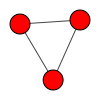

In [ ]:
igraph.drawing.plot(testgraph, bbox=[0,0,100,100])

In [ ]:
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic

In [91]:
!jupyter nbconvert --to html /content/drive/MyDrive/ColabNotebooks/copy_template.ipynb

[NbConvertApp] Converting notebook /content/drive/MyDrive/ColabNotebooks/copy_template.ipynb to html
Traceback (most recent call last):
  File "/usr/local/bin/jupyter-nbconvert", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.10/dist-packages/jupyter_core/application.py", line 283, in launch_instance
    super().launch_instance(argv=argv, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.10/dist-packages/nbconvert/nbconvertapp.py", line 423, in start
    self.convert_notebooks()
  File "/usr/local/lib/python3.10/dist-packages/nbconvert/nbconvertapp.py", line 597, in convert_notebooks
    self.convert_single_notebook(notebook_filename)
  File "/usr/local/lib/python3.10/dist-packages/nbconvert/nbconvertapp.py", line 560, in convert_single_notebook
    output, resources = self.export_single_notebook(
  File "/usr/local/lib/python3.10/dist-packages/